In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import numpy as np
import folium
from folium import plugins
%matplotlib inline

In [2]:
denver_data=pd.read_csv('crime.csv', parse_dates=True)

In [3]:
denver_data = denver_data.rename(columns={'offense_id':'OFFENSE_ID'})

In [4]:
denver_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479114 entries, 0 to 479113
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   incident_id             479114 non-null  int64  
 1   OFFENSE_ID              479114 non-null  int64  
 2   OFFENSE_CODE            479114 non-null  int64  
 3   OFFENSE_CODE_EXTENSION  479114 non-null  int64  
 4   OFFENSE_TYPE_ID         479114 non-null  object 
 5   OFFENSE_CATEGORY_ID     479114 non-null  object 
 6   FIRST_OCCURRENCE_DATE   479114 non-null  object 
 7   LAST_OCCURRENCE_DATE    178899 non-null  object 
 8   REPORTED_DATE           479114 non-null  object 
 9   INCIDENT_ADDRESS        440723 non-null  object 
 10  GEO_X                   475003 non-null  float64
 11  GEO_Y                   475003 non-null  float64
 12  GEO_LON                 475002 non-null  float64
 13  GEO_LAT                 475002 non-null  float64
 14  DISTRICT_ID         

In [20]:
temp=display(denver_data.groupby([denver_data.OFFENSE_CODE,denver_data.OFFENSE_CODE_EXTENSION,denver_data.OFFENSE_TYPE_ID]).size())
pd.set_option('display.max_rows',500)
print(temp)

OFFENSE_CODE  OFFENSE_CODE_EXTENSION  OFFENSE_TYPE_ID               
902           0                       homicide-family                      33
907           0                       homicide-police-by-gun                4
910           0                       homicide-negligent                    1
912           0                       homicide-other                      325
1006          0                       kidnap-adult-victim                 209
              1                       kidnap-dv                           217
1099          0                       false-imprisonment                  506
1102          0                       sex-aslt-rape                      2292
              1                       sex-aslt-rape-pot                   170
1109          0                       sex-aslt-non-rape                   626
              1                       sex-aslt-non-rape-pot               160
1113          0                       sex-asslt-sodomy-man-strng-arm     

None


######  Change the columns into datetime 

In [21]:
denver_data['REPORTED_DATE']=pd.to_datetime(denver_data.REPORTED_DATE)
denver_data['FIRST_OCCURRENCE_DATE']=pd.to_datetime(denver_data.FIRST_OCCURRENCE_DATE)
denver_data['LAST_OCCURRENCE_DATE']=pd.to_datetime(denver_data.LAST_OCCURRENCE_DATE)

In [27]:
temp=denver_data[['OFFENSE_ID','FIRST_OCCURRENCE_DATE','LAST_OCCURRENCE_DATE','REPORTED_DATE']]
temp.loc[:,'OCCURENCE_WINDOW']=temp.LAST_OCCURRENCE_DATE-temp.FIRST_OCCURRENCE_DATE
temp.loc[:,'OCCURENCE_WINDOW']=temp.OCCURENCE_WINDOW.fillna('0')
print(temp[temp['OCCURENCE_WINDOW']<'0'])
duds=temp[temp['OCCURENCE_WINDOW']<'0'].OFFENSE_ID
#remove rows with errors
denver_data=denver_data[~denver_data['OFFENSE_ID'].isin(duds)]

Empty DataFrame
Columns: [OFFENSE_ID, FIRST_OCCURRENCE_DATE, LAST_OCCURRENCE_DATE, REPORTED_DATE, OCCURENCE_WINDOW]
Index: []


In [ ]:
#Determine if there are mistakes in the OFFENSE_ID column
#prepare the columns
temp=denver_data[['OFFENSE_ID','INCIDENT_ID','OFFENSE_CODE','OFFENSE_CODE_EXTENSION']]
temp.OFFENSE_ID=temp.OFFENSE_ID.astype(str)
temp.INCIDENT_ID=temp.INCIDENT_ID.astype(str)
#the below two columns have to be homogonized to 4 digits and 2 digits respectively
temp.OFFENSE_CODE=temp.OFFENSE_CODE.map('{:04d}'.format).astype(str)
temp.OFFENSE_CODE_EXTENSION=temp.OFFENSE_CODE_EXTENSION.map('{:02d}'.format).astype(str)
#Combine the composite columns and check to make sure it's the same as the OFFENSE_ID
temp['COMBINED_ID']=temp.INCIDENT_ID+temp.OFFENSE_CODE+temp.OFFENSE_CODE_EXTENSION
temp['ID_MATCH']=temp.COMBINED_ID==temp.OFFENSE_ID
#print all rows which have mistakes. will return no rows if there are no errors
print(temp[temp['ID_MATCH']==False])

In [12]:
'*' * 125

'*****************************************************************************************************************************'

In [18]:
#filter out traffic accidents from the crime dataset
denver_crime=denver_data[denver_data['IS_CRIME']==1]
denver_crime=denver_crime[denver_crime['REPORTED_DATE']<'2023']
#add columns indicating the hour, day, month, and year eeach crime occurred
denver_crime['HOUR_REPORTED']=pd.DatetimeIndex(denver_crime['REPORTED_DATE']).hour
denver_crime['WEEKDAY_REPORTED']=pd.DatetimeIndex(denver_crime['REPORTED_DATE']).weekday
denver_crime['MONTH_REPORTED']=pd.DatetimeIndex(denver_crime['REPORTED_DATE']).month
denver_crime['YEAR_REPORTED']=pd.DatetimeIndex(denver_crime['REPORTED_DATE']).year

denver_crime

,incident_id,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,...,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,HOUR_REPORTED,WEEKDAY_REPORTED,MONTH_REPORTED,YEAR_REPORTED
0,20226000193,20226000193299900,2999,0,criminal-mischief-other,public-disorder,1/4/2022 11:30:00 AM,1/4/2022 12:00:00 PM,1/4/2022 8:36:00 PM,128 S CANOSA CT,...,39.714268,4.0,411.0,valverde,1,0,20,1,1,2022
1,20223319,20223319299900,2999,0,criminal-mischief-other,public-disorder,1/3/2022 6:45:00 AM,NaN,1/3/2022 11:01:00 AM,650 15TH ST,...,39.743649,6.0,611.0,cbd,1,0,11,0,1,2022
2,20223093,20223093299900,2999,0,criminal-mischief-other,public-disorder,1/3/2022 1:00:00 AM,NaN,1/3/2022 6:11:00 AM,919 E COLFAX AVE,...,39.740130,6.0,621.0,north-capitol-hill,1,0,6,0,1,2022
3,20224000,20224000299900,2999,0,criminal-mischief-other,public-disorder,1/3/2022 7:47:00 PM,NaN,1/3/2022 9:12:00 PM,2345 W ALAMEDA AVE,...,39.711518,4.0,411.0,valverde,1,0,21,0,1,2022
4,20223956,20223956299900,2999,0,criminal-mischief-other,public-disorder,1/3/2022 5:06:00 PM,NaN,1/3/2022 8:31:00 PM,7800 E SMITH RD,...,39.769688,5.0,512.0,central-park,1,0,20,0,1,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476436,202296138,202296138239900,2399,0,theft-other,larceny,2/18/2022 6:12:00 PM,2/25/2022 10:55:00 AM,2/25/2022 11:01:00 AM,400 BLK E 20TH AVE,...,39.747618,6.0,621.0,five-points,1,0,11,4,2,2022
476507,202291105,202291105260401,2604,1,fraud-criminal-impersonation,white-collar-crime,2/15/2022 8:00:00 AM,2/22/2022 10:57:00 AM,2/22/2022 10:57:00 AM,5023 N JASPER CT,...,39.786344,5.0,522.0,gateway-green-valley-ranch,1,0,10,1,2,2022
477208,202267624,202267624357200,3572,0,drug-methampetamine-possess,drug-alcohol,2/8/2022 1:00:00 PM,NaN,2/8/2022 1:00:00 PM,3500 BLK W ALASKA PL,...,39.708818,4.0,412.0,westwood,1,0,13,1,2,2022
478354,20215004495,20215004495200600,2006,0,arson-residence,arson,11/27/2021 6:00:00 PM,NaN,11/27/2021 6:05:00 PM,4400 BLK N LOGAN ST,...,39.777336,1.0,112.0,globeville,1,0,18,5,11,2021


###  Analysis

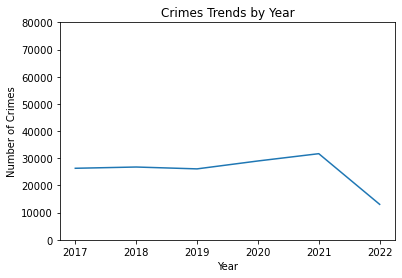

In [20]:
denver_crime['YEAR_REPORTED'].groupby(denver_crime.YEAR_REPORTED).agg('count').plot(kind='line')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.title('Crimes Trends by Year')
plt.ylim(bottom=0,top=80000)
plt.show()

###### Kinds of crimes being committed in Denver

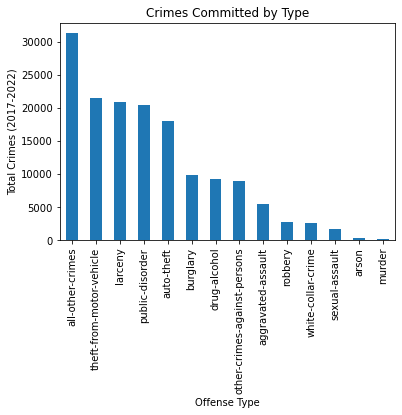

In [25]:
denver_crime['OFFENSE_CATEGORY_ID'].value_counts().plot(kind='bar')
plt.title('Crimes Committed by Type')
plt.xlabel('Offense Type')
plt.ylabel('Total Crimes (2017-2022)')
plt.show()

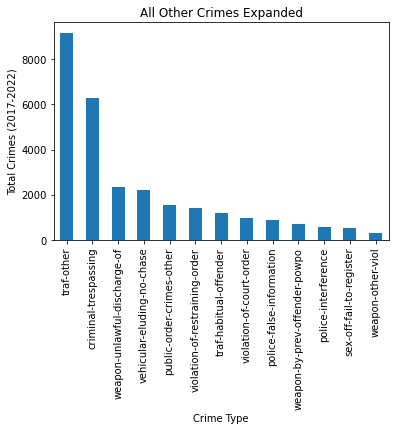

In [26]:
temp=denver_crime[denver_crime['OFFENSE_CATEGORY_ID']=='all-other-crimes'].OFFENSE_TYPE_ID.value_counts().head(13).plot(kind='bar')
plt.title('All Other Crimes Expanded')
plt.xlabel('Crime Type')
plt.ylabel('Total Crimes (2017-2022)')
plt.show()

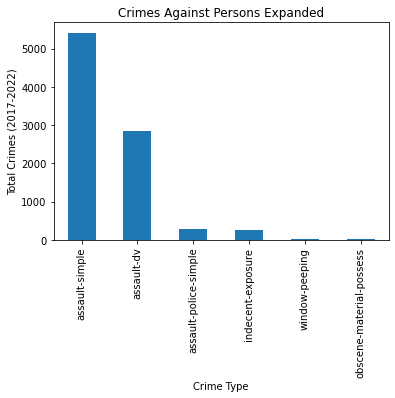

In [28]:
denver_misc_crimes=denver_crime[denver_crime['OFFENSE_CATEGORY_ID']=='other-crimes-against-persons'].OFFENSE_TYPE_ID.value_counts().plot(kind='bar')
plt.title('Crimes Against Persons Expanded')
plt.xlabel('Crime Type')
plt.ylabel('Total Crimes (2017-2022)')
plt.show()

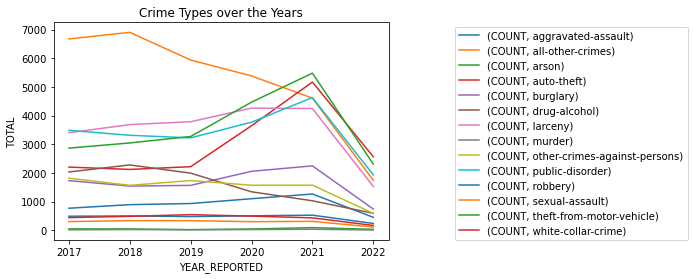

In [29]:
temp=denver_crime[['YEAR_REPORTED','OFFENSE_CATEGORY_ID']].groupby([denver_crime.YEAR_REPORTED, denver_crime.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='YEAR_REPORTED',axis=1)
temp.columns=['COUNT']
temp=temp.unstack(level=1)
temp.plot(kind='line')
plt.legend(loc=(1.2,0))
plt.ylabel('TOTAL')
plt.title('Crime Types over the Years')
plt.show()

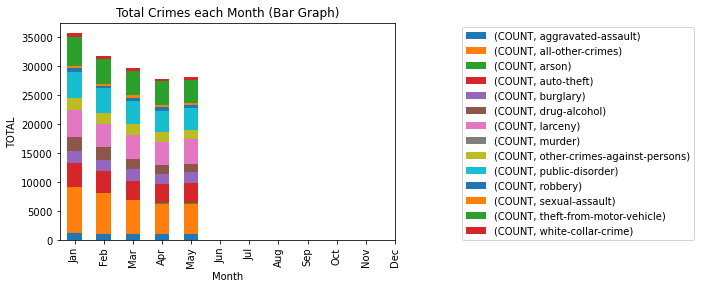

In [47]:
# br graph of crimes by month, to see if crime is seasonal
temp=denver_crime[['MONTH_REPORTED','OFFENSE_CATEGORY_ID']].groupby([denver_crime.MONTH_REPORTED, denver_crime.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='MONTH_REPORTED',axis=1)
temp.columns=['COUNT']
temp=temp.unstack(level=1)
ax=temp.plot(kind='bar',stacked=True)
plt.legend(loc=(1.2,0))
plt.title('Total Crimes each Month (Bar Graph)')
plt.xlabel('Month')
plt.ylabel('TOTAL')
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
plt.show()

C:\Users\Pavan Kumar\AppData\Local\Temp\ipykernel_25272\2899038841.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(('','Feb','Apr','Jun','Aug','Oct','Dec'))


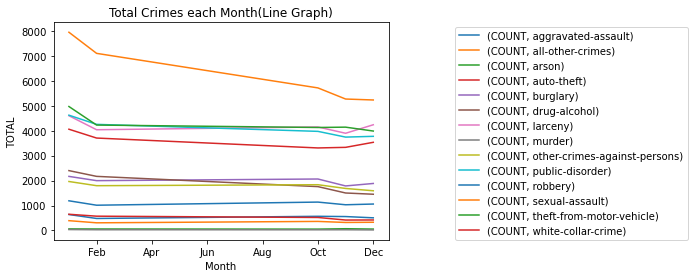

In [36]:
temp=denver_crime[['MONTH_REPORTED','OFFENSE_CATEGORY_ID']].groupby([denver_crime.MONTH_REPORTED, denver_crime.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='MONTH_REPORTED',axis=1)
temp.columns=['COUNT']
temp=temp.unstack(level=1)
ax=temp.plot(kind='line')
plt.legend(loc=(1.2,0))
plt.title('Total Crimes each Month(Line Graph)')
plt.xlabel('Month')
plt.ylabel('TOTAL')
ax.set_xticklabels(('','Feb','Apr','Jun','Aug','Oct','Dec'))

plt.show()

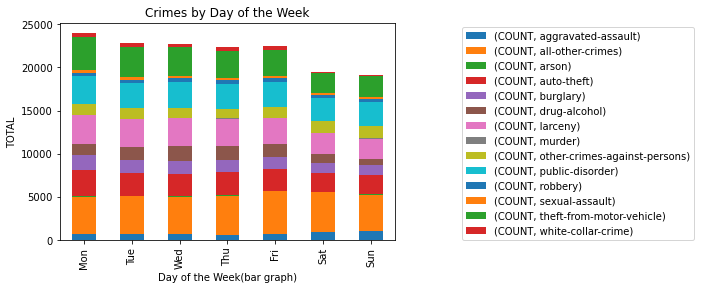

In [37]:
#bar graph of total crimes by day of the week
temp=denver_crime[['WEEKDAY_REPORTED','OFFENSE_CATEGORY_ID']].groupby([denver_crime.WEEKDAY_REPORTED, denver_crime.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='WEEKDAY_REPORTED',axis=1)
temp.columns=['COUNT']
temp=temp.unstack(level=1)
ax=temp.plot(kind='bar',stacked=True)
plt.legend(loc=(1.2,0))
plt.xlabel('Day of the Week(bar graph)')
plt.ylabel('TOTAL')
plt.title('Crimes by Day of the Week')
ax.set_xticklabels(('Mon','Tue','Wed','Thu','Fri','Sat','Sun'))
plt.show()

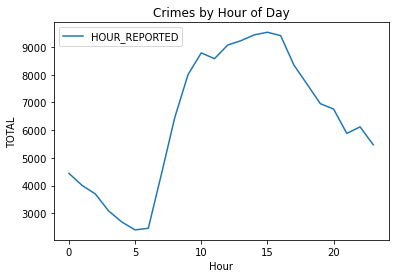

In [38]:
temp=denver_crime[['HOUR_REPORTED']].groupby([denver_crime.HOUR_REPORTED]).agg('count')
temp.plot(kind='line')
plt.xlabel('Hour')
plt.ylabel('TOTAL')
plt.title('Crimes by Hour of Day')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


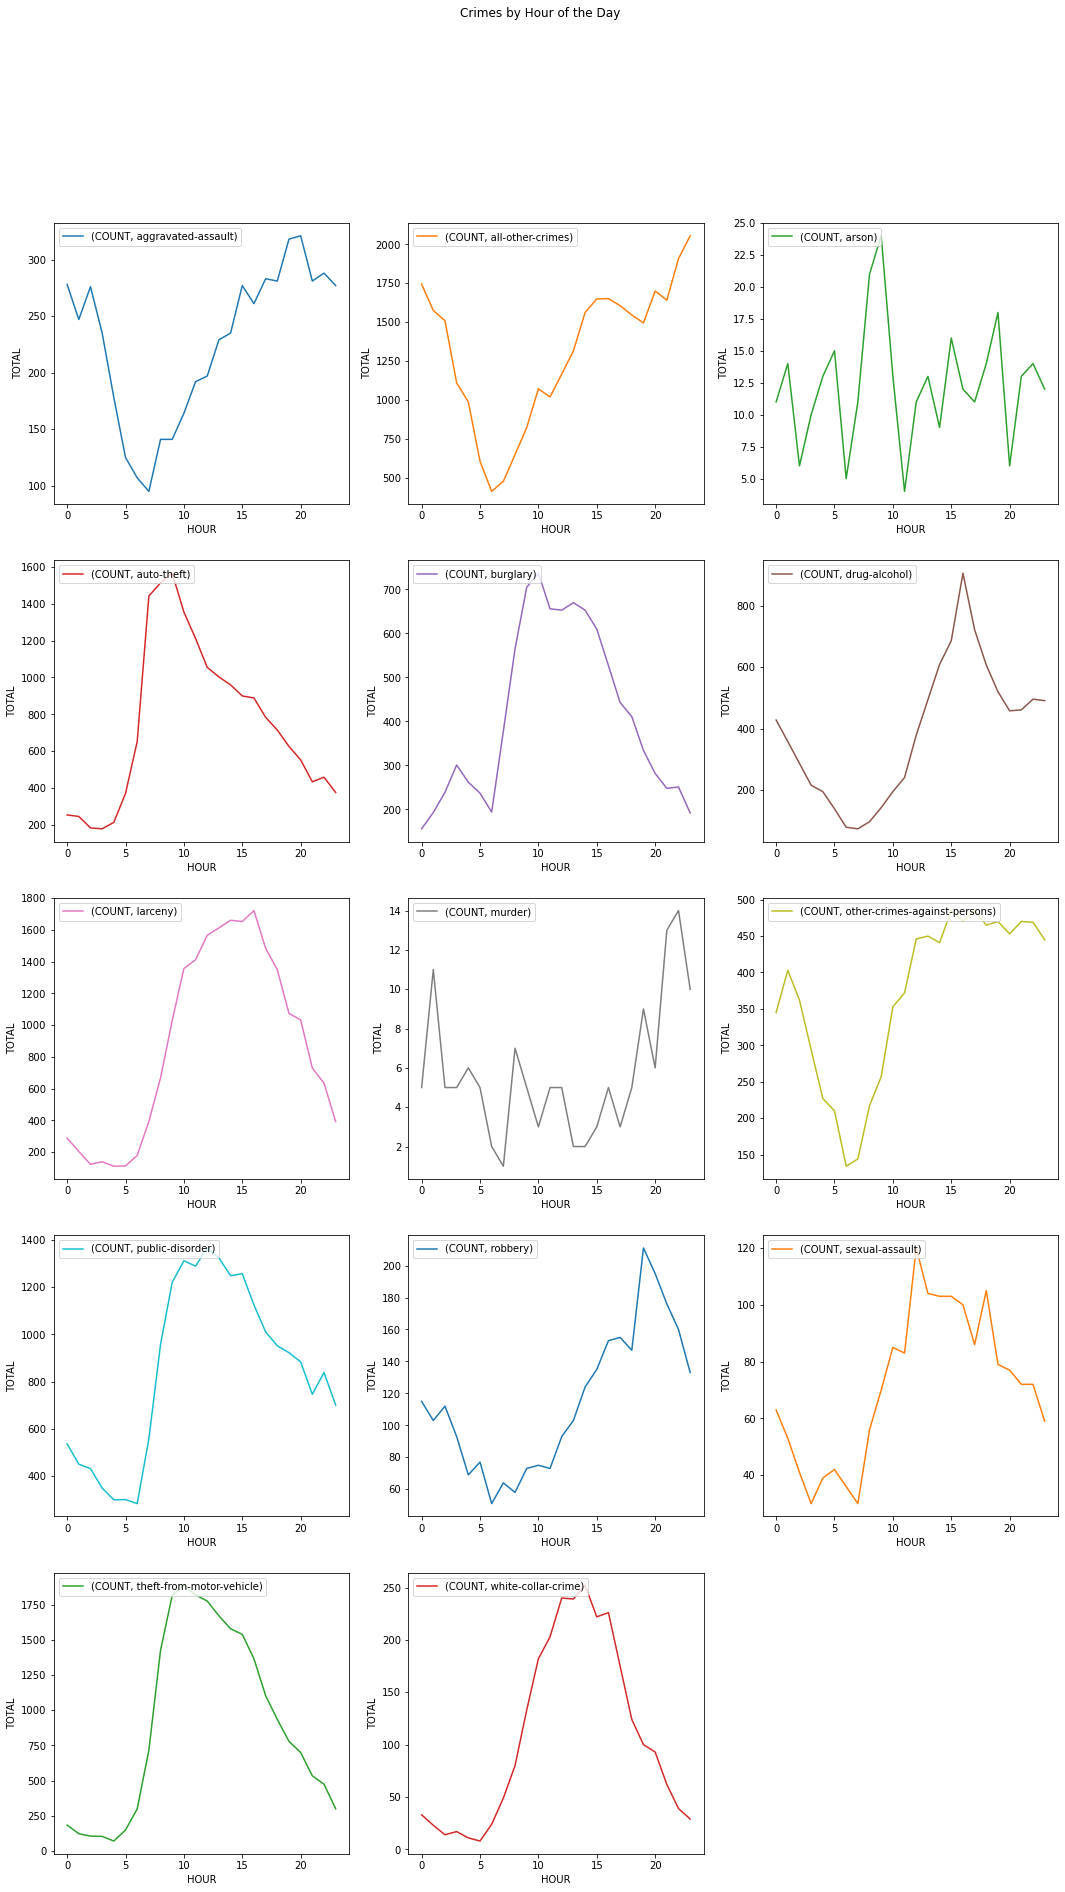

In [41]:
temp=denver_crime[['HOUR_REPORTED','OFFENSE_CATEGORY_ID']].groupby([denver_crime.HOUR_REPORTED, denver_crime.OFFENSE_CATEGORY_ID]).agg('count')
temp=temp.drop(labels='HOUR_REPORTED',axis=1)
temp.columns=['COUNT']
temp.index=temp.index.rename('HOUR',level=0)

temp=temp.unstack(level=1)
fig=temp.plot(kind='line', figsize=(18,30),subplots=True,layout=(-1,3),sharex=False,sharey=False)
for row in fig:
    for item in row:
        item.set_ylabel('TOTAL')
        item.legend(loc='upper left')
plt.suptitle('Crimes by Hour of the Day')
plt.show()